## SIMULAÇÃO LINHA ATUAL 

IMPORTS

In [60]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches



ETAPA 1 - OBTENDO INFORMAÇÕES YAMAZUMI

In [4]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()


# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

POSTOS_ATIVIDADES = {
    "Accelo": {'30A':{'atividades': ['ARREFEC'],'operadores': 1},'31A':{'atividades':['DIESEL','REAPERTO'], 'operadores':2},
               '32A':{'atividades':['ESTEPE','5AA_RODA'], 'operadores':2}, '32C':{'atividades':['PNEU_LD','PNEU_LE'], 'operadores':1},
                '33A':{'atividades':['APERTO_LD','APERTO_LE'],'operadores':2},'34A':{'atividades':['GRADE','MECACNICA_1','MECACNICA_2','ELECTRICA_1','ELECTRICA_2'],'operadores':2},
                '38':{'atividades':['CONTROLE','MOTORISTA','QUIS'],'operadores':1}},
    "Atego": {'30A':{'atividades': ['ARREFEC'],'operadores': 1},'31A':{'atividades':['DIESEL','REAPERTO'], 'operadores':2},
               '32A':{'atividades':['ESTEPE','5AA_RODA'], 'operadores':2}, '32C':{'atividades':['PNEU_LD','PNEU_LE'], 'operadores':1},
                '33A':{'atividades':['APERTO_LD','APERTO_LE'],'operadores':2},'34A':{'atividades':['GRADE','MECACNICA_1','MECACNICA_2','ELECTRICA_1','ELECTRICA_2'],'operadores':2},
                '38':{'atividades':['CONTROLE','MOTORISTA','QUIS'],'operadores':1}},
    "Atego (ATP)":{'30A':{'atividades': ['ARREFEC'],'operadores': 1},'31A':{'atividades':['DIESEL','REAPERTO'], 'operadores':2},
               '32A':{'atividades':['ESTEPE'], 'operadores':2}, '32C':{'atividades':['5AA_RODA','PNEU_LD','PNEU_LE'], 'operadores':1},
                '33A':{'atividades':['APERTO_LD','APERTO_LE'],'operadores':2},'34A':{'atividades':['GRADE','MECACNICA_1','MECACNICA_2','ELECTRICA_1','ELECTRICA_2'],'operadores':2},
                '38':{'atividades':['CONTROLE','MOTORISTA','QUIS'],'operadores':1}}, 
    "Actros":{"30B": {'atividades':["ABASTECIMENTO"],'operadores':2}, "31B": {'atividades':[ "PASSADISASSO"],'operadores':2},
              '32B':{'atividades':['CHINELEIRA'],'operadores':2},'32D':{'atividades':['5AA_RODA'],'operadores':2},
              '33B':{'atividades':['PNEU_LD','PNEU_LE'],'operadores':2}, '34B':{'atividades':['PARALAMA_LD','PARALAMA_LE'],'operadores':2}, 
              '39':{'atividades':['CONTROLE','ELACTRICA_I''ELACTRICA_II','ELACTRICA_3','COLUNA5'],'operadores':2}},
    "Arocs": {"30B": {'atividades':["ABASTECIMENTO"],'operadores':2}, "31B": {'atividades':[ "PASSADISASSO"],'operadores':2},
              '32B':{'atividades':['CHINELEIRA'],'operadores':2},'32D':{'atividades':['5AA_RODA'],'operadores':2},
              '33B':{'atividades':['PNEU_LD','PNEU_LE'],'operadores':2}, '34B':{'atividades':['PARALAMA_LD','PARALAMA_LE'],'operadores':2}, 
              '39':{'atividades':['CONTROLE','ELACTRICA_I''ELACTRICA_II','ELACTRICA_3','COLUNA5'],'operadores':2}},
    "Axor (ATP +)":{"30B": {'atividades':["ABASTECIMENTO"],'operadores':2}, "31B": {'atividades':[ "PASSADISASSO"],'operadores':2},
              '32B':{'atividades':['CHINELEIRA'],'operadores':2},'32D':{'atividades':['5AA_RODA'],'operadores':2},
              '33B':{'atividades':['PNEU_LD','PNEU_LE'],'operadores':2}, '34B':{'atividades':['PARALAMA_LD','PARALAMA_LE'],'operadores':2}, 
              '39':{'atividades':['CONTROLE','ELACTRICA_I''ELACTRICA_II','ELACTRICA_3','COLUNA5'],'operadores':2}}
}


# DICIONÁRIO COM SOMA DOS TEMPOS POR POSTOS E TEMPOS POR OPERADOR
resultado = {}
for modelo, info in MODELOS_CSV.items():
    arquivo_csv = info["tempos"]
    tempos_atividades = get_process_times_from_csv(arquivo_csv)
    print(tempos_atividades)
    
    postos_dict = {}
    for posto, valor in POSTOS_ATIVIDADES[modelo].items():
        soma_tempo = sum(tempos_atividades.get(a.upper(), 0) for a in valor['atividades'])
        #print(soma_tempo)
        num_op = valor['operadores']
        tempo_op = soma_tempo / num_op if num_op != 0 else 0
        postos_dict[posto] = {
            'tempo_total': tempo_op*num_op,
            'operador': num_op,
            'tempo_operador': tempo_op
        }
    
    resultado[modelo] = postos_dict

#print(resultado)
#print(postos_dict)
# print(list(resultado[modelo].keys()))

# --- Exibe resultado final ---
print("\n--- Tempos por posto por modelo ---")
for modelo, valor in resultado.items():
    print(f"{modelo}: {valor}")

{'ARREFEC': 316, 'DIESEL': 253, 'REAPERTO': 235, 'ESTEPE': 290, 'PNEU_LD': 250, 'PNEU_LE': 250, 'APERTO_LD': 304, 'APERTO_LE': 304, 'GRADE': 270, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 357, 'ELACTRICA_2': 357, 'CONTROLE': 265, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 314, 'DIESEL': 314, 'REAPERTO': 294, 'ESTEPE': 267, 'PNEU_LD': 308, 'PNEU_LE': 308, 'APERTO_LD': 315, 'APERTO_LE': 315, 'GRADE': 234, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 330, 'DIESEL': 326, 'REAPERTO': 557, '5AA_RODA': 724, 'ESTEPE': 319, 'PNEU_LD': 256, 'PNEU_LE': 256, 'APERTO_LD': 323, 'APERTO_LE': 323, 'GRADE': 230, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ABASTECIMENTO': 555, 'PASSADISASSO': 752, 'CHINELEIRA': 965, '5AA_RODA': 988, 'PNEU_LD': 407, 'PNEU_LE': 407, 'PARALAMA_LD': 800, 'PARALAMA_LE': 800, 'CONTROLE

ETAPA 2: OBTENDO DADOS SEQUENCIA DO DIA

In [5]:
sequencia = pd.read_csv("sequencia_producao.csv", sep=';')

# Extrai os 7 primeiros caracteres da coluna 'Baumuster'
sequencia['Baumuster_7dig'] = sequencia['Baumuster'].astype(str).str[:7]
sequencia_modelos = sequencia["Baumuster_7dig"].tolist()
print(sequencia_modelos)

['C951501', 'C951501', 'C968403', 'C968450', 'C951102', 'C963425', 'C951501', 'C968114', 'C951501', 'C951104', 'C951501', 'C963425', 'C951501', 'C968114', 'C951104', 'C963414', 'C963425', 'C963411', 'C963414', 'C951104', 'C968403', 'C951102', 'C963425', 'C951501', 'C951102', 'C951501', 'C968403', 'C963425', 'C951104', 'C951544', 'C951501', 'C963414', 'C951501', 'C951501', 'C951501', 'C963411', 'C951511', 'C951104', 'C951501', 'C963425', 'C951501', 'C951511', 'C951104', 'C963425', 'C951501', 'C968403', 'C951501', 'C963425', 'C951104', 'C968403', 'C951501', 'C963425', 'C951104', 'C951104', 'C963425', 'C951501', 'C951514', 'C963414', 'C951104', 'C951544', 'C951501', 'C951544', 'C951511', 'C963425', 'C951514', 'C951511', 'C963411', 'C951501', 'C968403', 'C951104', 'C963425', 'C951102', 'C951500', 'C951511', 'C963414', 'C951104', 'C951511', 'C951104', 'C963425', 'C951511', 'C951501', 'C964016', 'C951511', 'C951102', 'C968450', 'C951501', 'C963425', 'C951501', 'C968114', 'C951104', 'C951104'

ETAPA 3: OBTENDO QUANTOS MODELOS SÃO PRODUZIDOS POR PERNA POR TURNO

Consideramos a espera para entrar em um posto, apenas 1 modelo pode ocupar 1 posto

In [61]:
TAKT_TIME=5.5*60
TURN_DURATION=8*3600

log_entrada_saida = [] # Lista vazia criada para guardar informações de entrada, saída e duração do modelo

# Função PROCESSAR_MODELO() simula a trajetória de um modelo pela linha de montagem:
# env é o ambiente de simulação do SimPy.
# nome é o nome único desse modelo na simulação, ex: "Actros_5".
# postos_dict é um dicionário com os postos que esse modelo vai passar, com tempos por posto.

def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_total"]
        with recursos[posto].request() as req: # pede o recurso do posto (garante que só um modelo usa por vez)
            entrada = env.now
            yield req #espera se necessário (yield req)
            yield env.timeout(tempo_tot) # espera o tempo de montagem (yield env.timeout(tempo_tot))
            saida = env.now

            # registra entrada, saída e duração no log
            log_entrada_saida.append({
                "modelo": modelo_nome,
                "nome": nome,
                "posto": posto,
                "entrada": entrada,
                "saida": saida,
                "duracao": saida - entrada,
                "perna": perna
            })

# Função SIMULACAO_LINHA cria o ambiente da simulação
# recursos: dicionário onde cada posto é um simpy.Resource() com capacity=1.
# ultimo_tempo_entrada_global: impede que dois modelos entrem no mesmo instante.
# disponibilidade_postos: controla quando o primeiro posto da perna estará livre para o próximo veículo.

def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

    env = simpy.Environment() # criando ambiente simulação
    
    # Ferramentas auxiliares na função:
    recursos = {} # dicionário onde cada posto é um simpy.Resource() com capacity=1;nenhum posto pode ser ocupado por mais de um modelo
    ultimo_tempo_entrada_global = 0  # ninguém entra na linha antes disso, impede que dois modelos entrem no mesmo instante nas pernas
    disponibilidade_postos = {}  # armazena quando o primeiro posto de cada perna estará livre para próximo veículo entrar

    # Função ALIMENTADOR() coloca os modelos na linha, respeitando o espaçamento (TAKT) e disponibilidade do primeiro posto.
    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        # Identificando qual modelo corresponde ao baumuster da sequência e sua perna
        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, perna = None, None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    perna = dados["perna"]
                    break
            if modelo_nome is None:
                continue
            
            # Define o primeiro posto que o modelo ocupará e quanto tempo levará nesse posto
            postos_dict = resultado[modelo_nome]
            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_total"]

            # Inicializa a disponibilidade se for a primeira vez usando esse posto
            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0
            
            # só entra um modelo por vez no primeiro posto de cada perna;
            # o espaçamento entre modelos é de ao menos TAKT_TIME;
            # respeita o tempo mínimo em que o posto estará livre.

            # Espera até que seja possível entrar na linha
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,  # garante espaçamento global
                tempo_disponivel_posto  # garante que o primeiro posto da perna está livre
            )

            yield env.timeout(entrada_sugerida - env.now)

            # Atualiza os controles de entrada
            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # Cria os recursos dos postos, se necessário (caso não tenha sido criado)
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            # Inicia processo de montagem
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos
            ))
    
    # Inicia simulação, rodando até duração do turno
    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    return pd.DataFrame(log_entrada_saida)


In [9]:

# Executa a simulação
df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION)

# Mostra todas as linhas (se quiser ver tudo)
pd.set_option('display.max_rows', None)

# Exibe o DataFrame com entradas e saídas por modelo/posto
print(df_log)

           modelo            nome posto  entrada    saida  duracao  perna
0           Atego         Atego_0   30A    330.0    644.0    314.0      1
1           Atego         Atego_1   30A    660.0    974.0    314.0      1
2           Atego         Atego_0   31A    644.0   1252.0    608.0      1
3     Atego (ATP)   Atego (ATP)_2   30A    990.0   1320.0    330.0      1
4           Atego         Atego_0   32A   1252.0   1519.0    267.0      1
5           Atego         Atego_1   31A    974.0   1860.0    886.0      1
6    Axor (ATP +)  Axor (ATP +)_3   30B   1320.0   1875.0    555.0      2
7          Accelo        Accelo_4   30A   1650.0   1966.0    316.0      1
8           Atego         Atego_1   32A   1860.0   2127.0    267.0      1
9           Atego         Atego_0   32C   1519.0   2135.0    616.0      1
10         Actros        Actros_5   30B   1980.0   2535.0    555.0      2
11          Atego         Atego_6   30A   2310.0   2624.0    314.0      1
12   Axor (ATP +)  Axor (ATP +)_3   31

In [10]:
def resumo_simulacao(df_log):
    import pandas as pd

    # 1. Quantidade de modelos produzidos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por modelo por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio por perna (tempo médio por posto / número de postos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60  # em minutos

    # Exibindo os resultados
    print("Quantidade de modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        print(f"  Perna {perna}: {qtd} modelos")

    print("\nTempo médio de produção de um modelo por perna (em minutos):")
    for perna, tempo in tempo_medio_producao.items():
        print(f"  Perna {perna}: {tempo:.2f} minutos")

    print("\nTakt time médio por perna (média dos tempos de ocupação por posto, em minutos):")
    for perna, takt in takt_time_medio.items():
        print(f"  Perna {perna}: {takt:.2f} minutos")

print(resumo_simulacao(df_log))


Quantidade de modelos produzidos por perna:
  Perna 1: 61 modelos
  Perna 2: 23 modelos

Tempo médio de produção de um modelo por perna (em minutos):
  Perna 1: 109.98 minutos
  Perna 2: 116.22 minutos

Takt time médio por perna (média dos tempos de ocupação por posto, em minutos):
  Perna 1: 24.19 minutos
  Perna 2: 22.00 minutos
None


ETAPA 4: OUTPUTS GRÁFICOS  

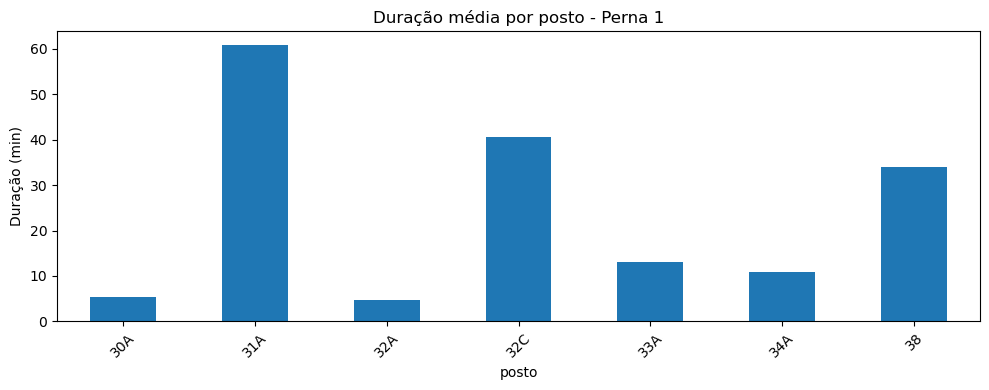

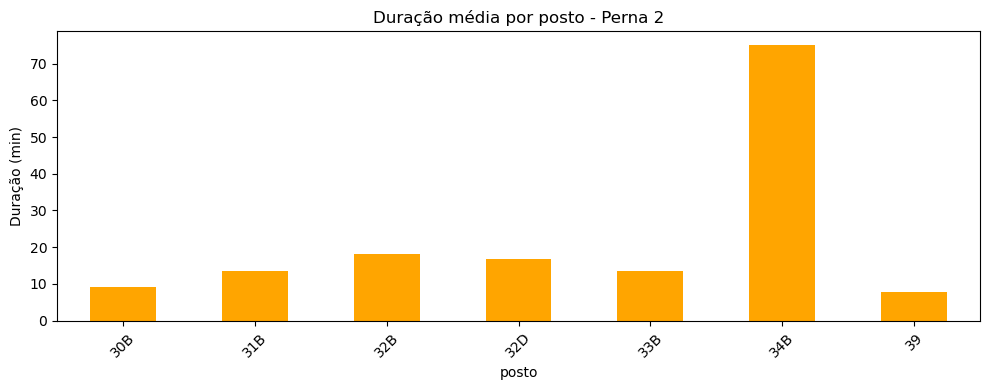

In [59]:


# Supondo que df_log já foi criado com a simulação
df_log["duracao_min"] = df_log["duracao"] / 60

# Filtra e agrupa por perna 1
media_perna1 = df_log[df_log["perna"] == 1].groupby("posto")["duracao_min"].mean()
plt.figure(figsize=(10, 4))
media_perna1.plot(kind='bar')
plt.title("Duração média por posto - Perna 1")
plt.ylabel("Duração (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filtra e agrupa por perna 2
media_perna2 = df_log[df_log["perna"] == 2].groupby("posto")["duracao_min"].mean()
plt.figure(figsize=(10, 4))
media_perna2.plot(kind='bar', color='orange')
plt.title("Duração média por posto - Perna 2")
plt.ylabel("Duração (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

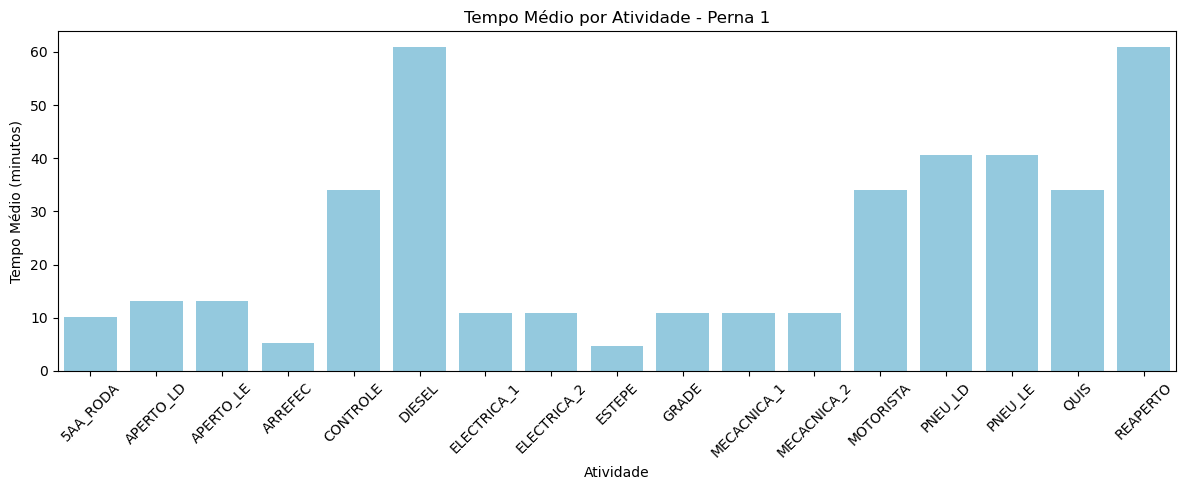

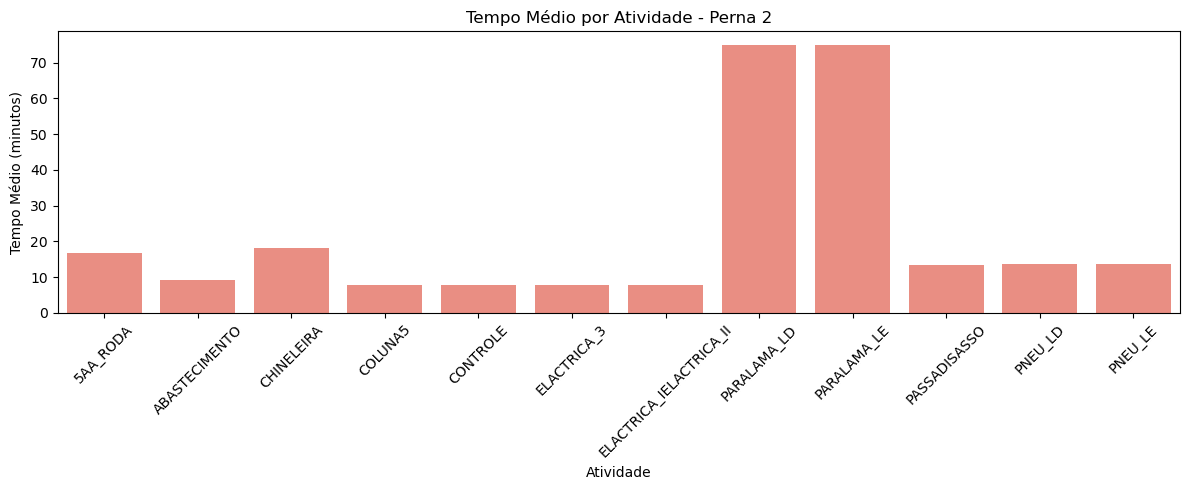

In [28]:

# 1. Mapeia atividades por (modelo, posto)
atividade_map = defaultdict(list)
for modelo, postos in POSTOS_ATIVIDADES.items():
    for posto, info in postos.items():
        for atividade in info.get("atividades", []):
            atividade_map[(modelo, posto)].append(atividade)

# 2. Expande df_log com as atividades
atividades_expandidas = []
for _, row in df_log.iterrows():
    modelo = row["modelo"]
    posto = row["posto"]
    chave = (modelo, posto)
    atividades = atividade_map.get(chave, [])
    for atividade in atividades:
        atividades_expandidas.append({
            "perna": row["perna"],
            "atividade": atividade,
            "duracao_min": row["duracao"] / 60  # segundos → minutos
        })

df_atividades = pd.DataFrame(atividades_expandidas)

# 3. Agrupa por perna e atividade
tempo_medio_atividade_perna = df_atividades.groupby(["perna", "atividade"])["duracao_min"].mean().reset_index()

# 4. Gráfico para Perna 1
plt.figure(figsize=(12, 5))
sns.barplot(data=tempo_medio_atividade_perna.query("perna == 1"),
            x="atividade", y="duracao_min", color='skyblue')
plt.title("Tempo Médio por Atividade - Perna 1")
plt.xlabel("Atividade")
plt.ylabel("Tempo Médio (minutos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Gráfico para Perna 2
plt.figure(figsize=(12, 5))
sns.barplot(data=tempo_medio_atividade_perna.query("perna == 2"),
            x="atividade", y="duracao_min", color='salmon')
plt.title("Tempo Médio por Atividade - Perna 2")
plt.xlabel("Atividade")
plt.ylabel("Tempo Médio (minutos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

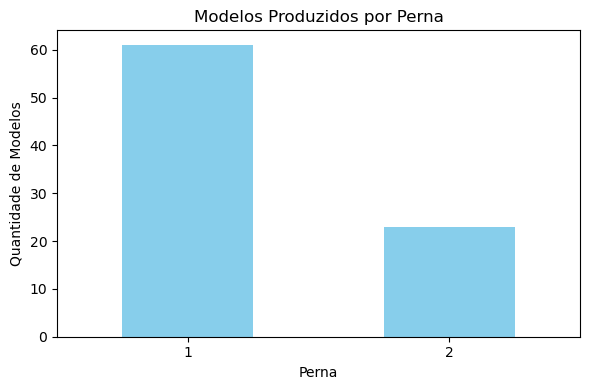

In [31]:
# Conta os modelos únicos por perna
modelos_por_perna = df_log.groupby("perna")["nome"].nunique()

# Gráfico de barras
plt.figure(figsize=(6, 4))
modelos_por_perna.plot(kind='bar', color='skyblue')
 
plt.title("Modelos Produzidos por Perna")
plt.xlabel("Perna")
plt.ylabel("Quantidade de Modelos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

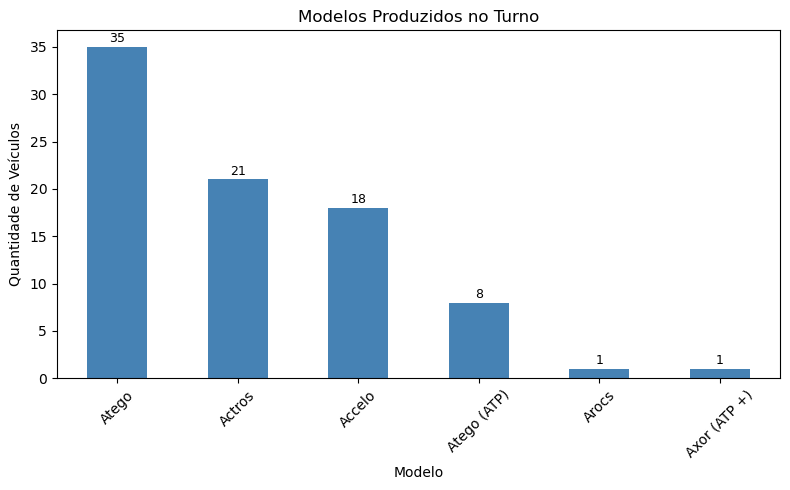

In [16]:
# Conta quantos modelos de cada tipo (modelo_nome) foram produzidos
modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(8, 5))
modelos_produzidos.plot(kind='bar', color='steelblue')

# Adiciona rótulos em cima das barras
for i, valor in enumerate(modelos_produzidos):
    plt.text(i, valor + 0.2, f"{valor}" , ha='center', va='bottom', fontsize=9)

plt.title("Modelos Produzidos no Turno")
plt.xlabel("Modelo")
plt.ylabel("Quantidade de Veículos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_17564\3258485265.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3")


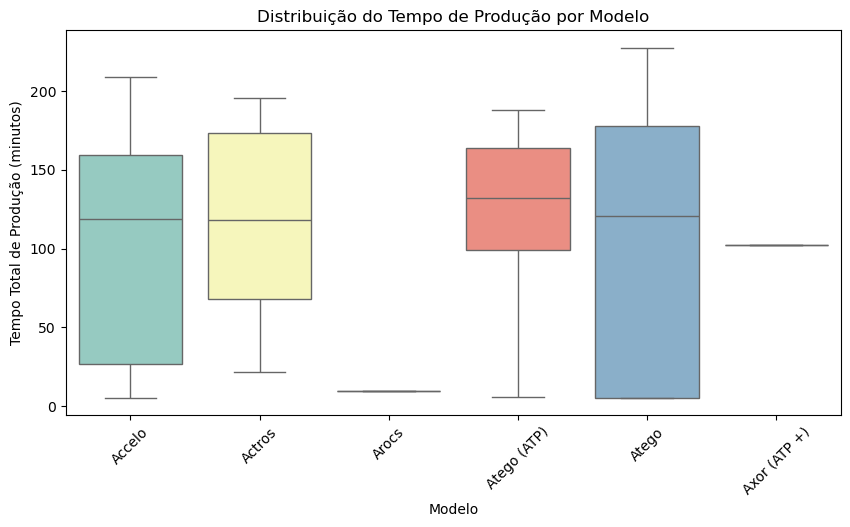

In [21]:
# Tempo total por modelo individual (nome), com identificação do tipo de modelo (ex: Accelo, Atego)
df_tempo_modelos = df_log.groupby("nome").agg(
    modelo=("modelo", "first"),
    tempo_total_min=("duracao", "sum")
).reset_index()
df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3")
plt.title("Distribuição do Tempo de Produção por Modelo")
plt.xlabel("Modelo")
plt.ylabel("Tempo Total de Produção (minutos)")
plt.xticks(rotation=45)
plt.show()

   posto  perna   duracao
0    30A      1   19318.0
1    30B      2   12765.0
2    31A      1  164227.0
3    31B      2   17841.0
4    32A      1   12678.0
5    32B      2   22798.0
6    32C      1   92542.0
7    32D      2   21116.0
8    33A      1   28962.0
9    33B      2   16280.0
10   34A      1   23470.0
11   34B      2   63017.0
12    38      1   61315.0
13    39      2    6566.0


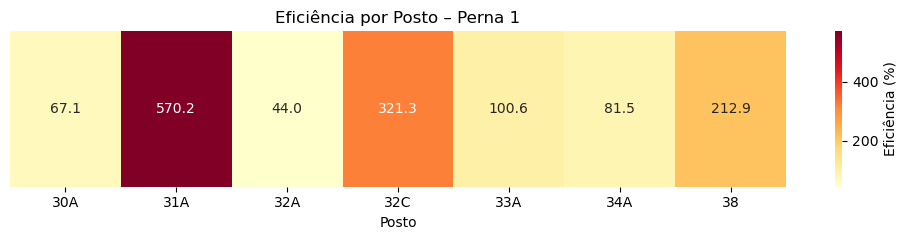

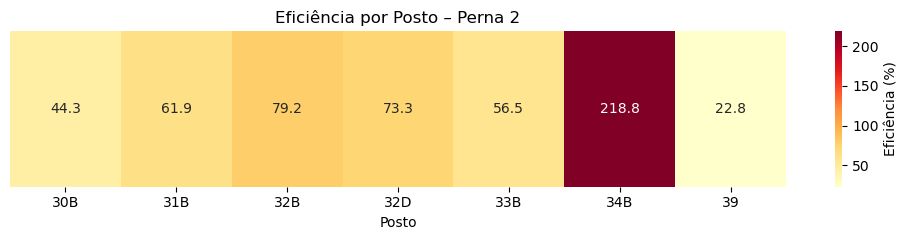

In [42]:
# ESSES GRÁFICOS NÃO ESTÃO FAZENDO SENTIDO

# Garante formatação correta
df_log["posto"] = df_log["posto"].astype(str)
df_log["perna"] = df_log["perna"].astype(int)

# Soma o tempo de ocupação por posto e por perna
tempo_ativo = df_log.groupby(["posto", "perna"])["duracao"].sum().reset_index()

print(tempo_ativo)
# Calcula eficiência (% do tempo do turno)
tempo_ativo["eficiencia"] = 100 * tempo_ativo["duracao"] / TURN_DURATION

# Ordenador para manter 30A, 31A, etc. em ordem lógica
def sort_key(posto):
    import re
    m = re.match(r"(\d+)([A-Z]*)", posto)
    return (int(m.group(1)), m.group(2))

# Gera heatmap separado para cada perna
for perna_id in sorted(tempo_ativo["perna"].unique()):
    dados = tempo_ativo[tempo_ativo["perna"] == perna_id].copy()
    dados = dados.sort_values("posto", key=lambda x: x.map(sort_key))

    # Constrói DataFrame formatado para heatmap (1 linha, n colunas)
    heatmap_df = dados.set_index("posto")[["eficiencia"]].T

    # Gráfico
    plt.figure(figsize=(10, 2.5))
    sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Eficiência (%)'})
    plt.title(f"Eficiência por Posto – Perna {perna_id}")
    plt.xlabel("Posto")
    plt.yticks([])
    plt.tight_layout()
    plt.show()


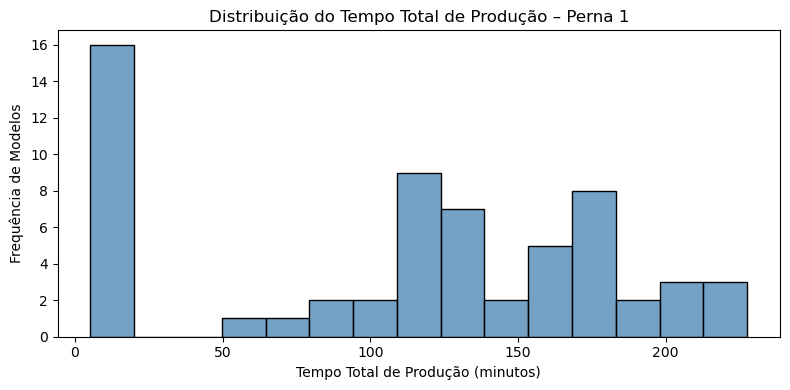

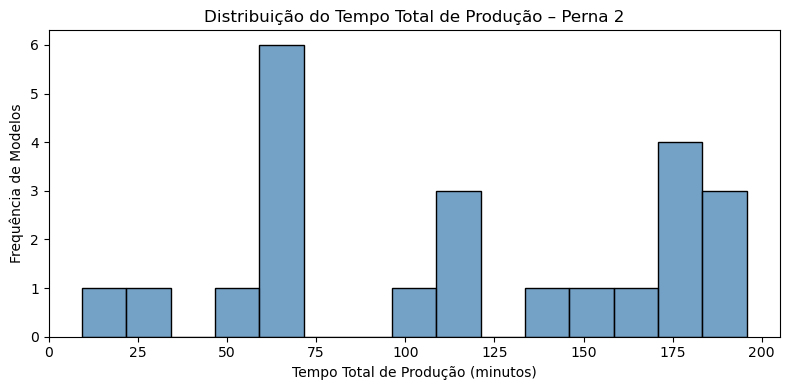

In [41]:
# ESSE GRÁFICO NÃO ESTÁ FAZENDO SENTIDO

# Calcula entrada e saída total por modelo
modelos_completos = df_log.groupby("nome").agg(
    perna=("perna", "first"),
    entrada_total=("entrada", "min"),
    saida_total=("saida", "max")
)

# Tempo total = saída - entrada
modelos_completos["tempo_total_min"] = (modelos_completos["saida_total"] - modelos_completos["entrada_total"]) / 60


for perna_id in sorted(modelos_completos["perna"].unique()):
    dados_perna = modelos_completos[modelos_completos["perna"] == perna_id]["tempo_total_min"]

    plt.figure(figsize=(8, 4))
    sns.histplot(dados_perna, bins=15, kde=False, color='steelblue')
    plt.title(f"Distribuição do Tempo Total de Produção – Perna {perna_id}")
    plt.xlabel("Tempo Total de Produção (minutos)")
    plt.ylabel("Frequência de Modelos")
    plt.tight_layout()
    plt.show()


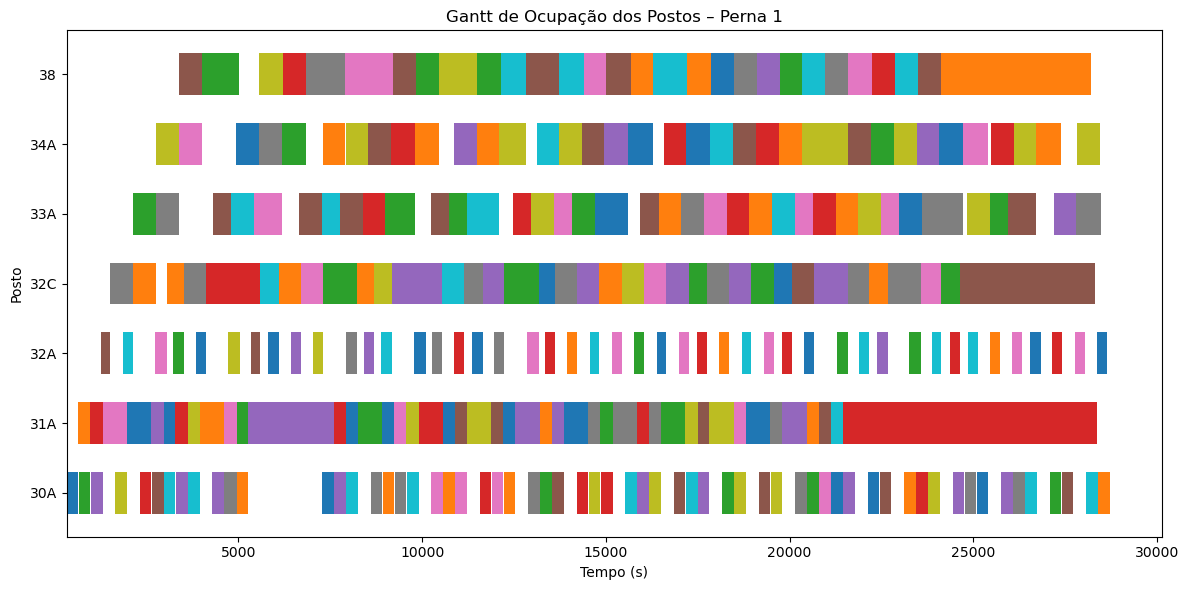

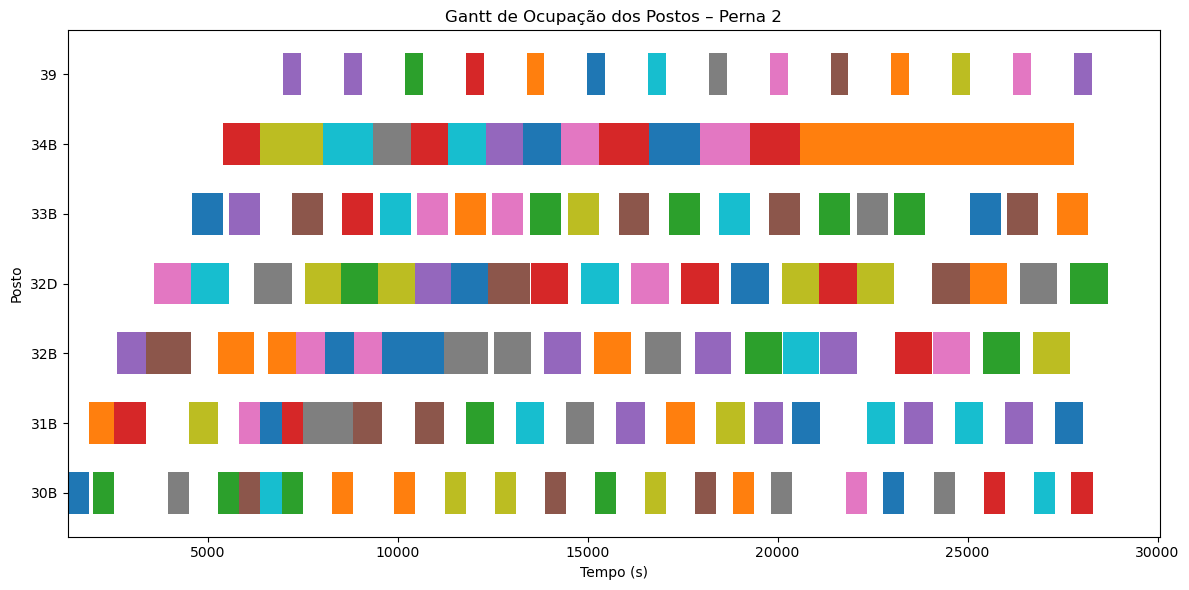

In [43]:

for perna_id in sorted(df_log["perna"].unique()):
    gantt_data = df_log[df_log["perna"] == perna_id].copy()
    gantt_data.sort_values("entrada", inplace=True)

    plt.figure(figsize=(12, 6))
    for i, row in gantt_data.iterrows():
        plt.barh(row["posto"], row["duracao"], left=row["entrada"], height=0.6)

    plt.title(f"Gantt de Ocupação dos Postos – Perna {perna_id}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Posto")
    plt.tight_layout()
    plt.show()

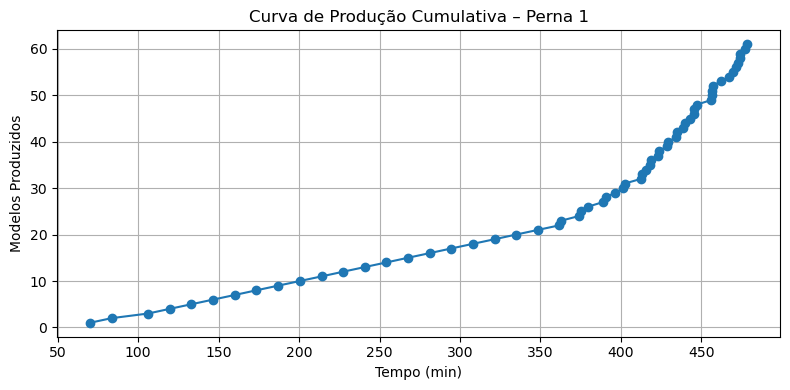

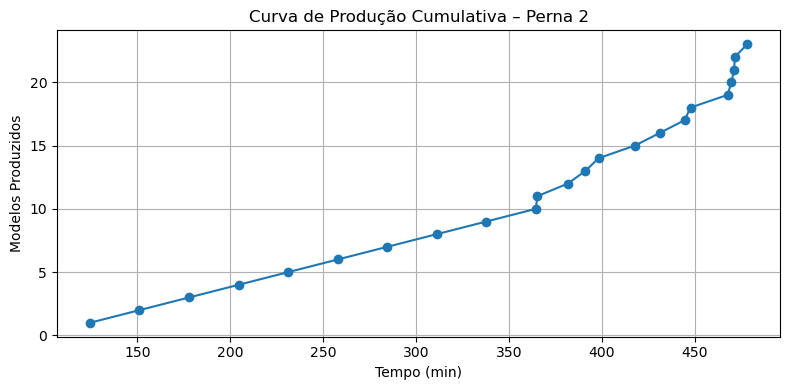

In [44]:
for perna_id in sorted(modelos_completos["perna"].unique()):
    dados = modelos_completos[modelos_completos["perna"] == perna_id].copy()
    dados = dados.sort_values("saida_total")
    dados["cumulado"] = range(1, len(dados) + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(dados["saida_total"] / 60, dados["cumulado"], marker='o')
    plt.title(f"Curva de Produção Cumulativa – Perna {perna_id}")
    plt.xlabel("Tempo (min)")
    plt.ylabel("Modelos Produzidos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


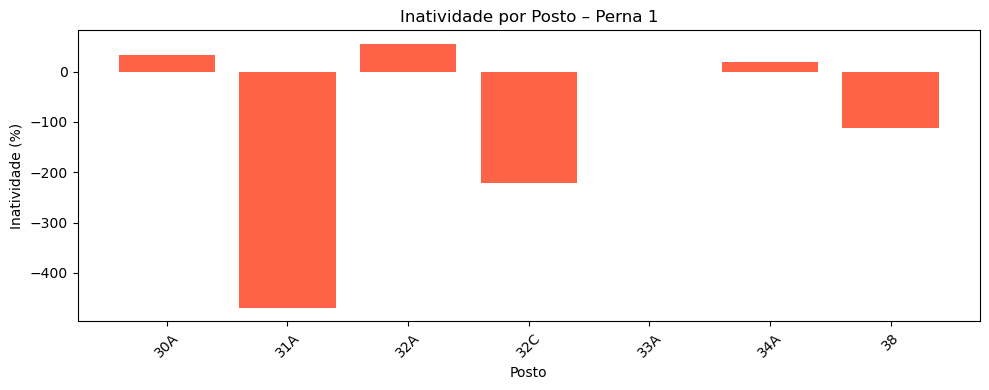

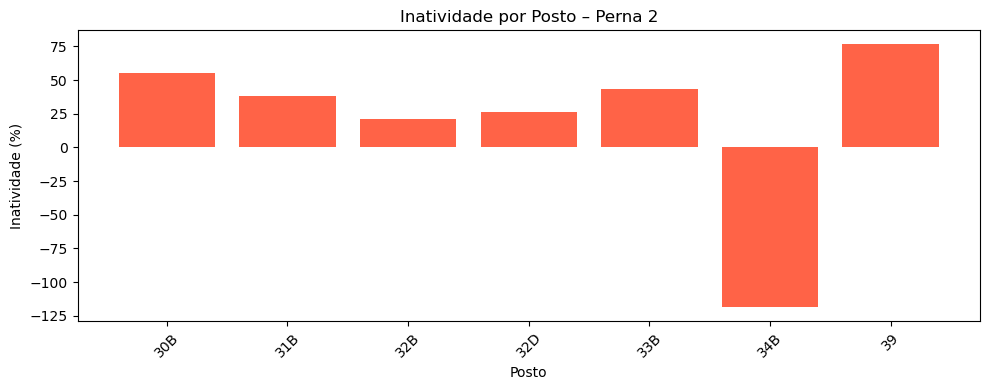

In [46]:


uso_postos = df_log.groupby(["posto", "perna"])["duracao"].sum().reset_index()
uso_postos["inatividade"] = TURN_DURATION - uso_postos["duracao"]
uso_postos["% inatividade"] = 100 * uso_postos["inatividade"] / TURN_DURATION

for perna_id in sorted(uso_postos["perna"].unique()):
    dados = uso_postos[uso_postos["perna"] == perna_id].copy().sort_values("posto")

    plt.figure(figsize=(10, 4))
    plt.bar(dados["posto"], dados["% inatividade"], color='tomato')
    plt.title(f"Inatividade por Posto – Perna {perna_id}")
    plt.ylabel("Inatividade (%)")
    plt.xlabel("Posto")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


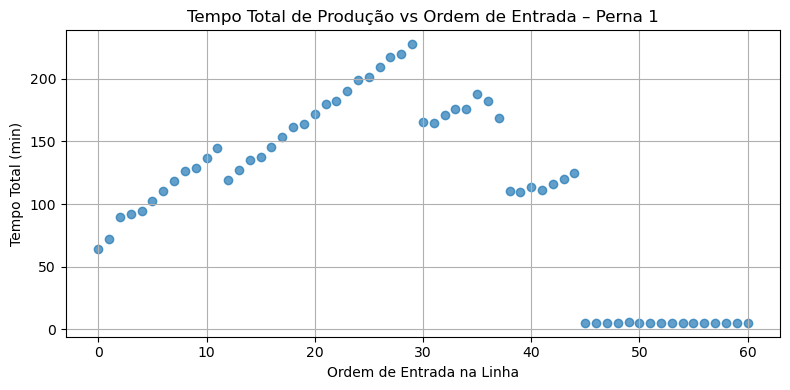

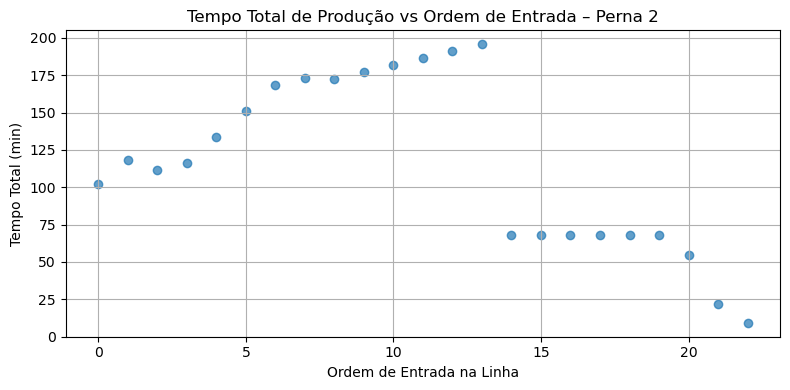

In [49]:
modelos_completos = df_log.groupby("nome").agg(
    modelo=("modelo", "first"),
    perna=("perna", "first"),
    entrada_total=("entrada", "min"),
    saida_total=("saida", "max")
)
modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]

for perna_id in sorted(modelos_completos["perna"].unique()):
    dados = modelos_completos[modelos_completos["perna"] == perna_id].copy()
    dados = dados.sort_values("entrada_total").reset_index()

    plt.figure(figsize=(8, 4))
    plt.scatter(dados.index, dados["tempo_total"] / 60, alpha=0.7)
    plt.title(f"Tempo Total de Produção vs Ordem de Entrada – Perna {perna_id}")
    plt.xlabel("Ordem de Entrada na Linha")
    plt.ylabel("Tempo Total (min)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


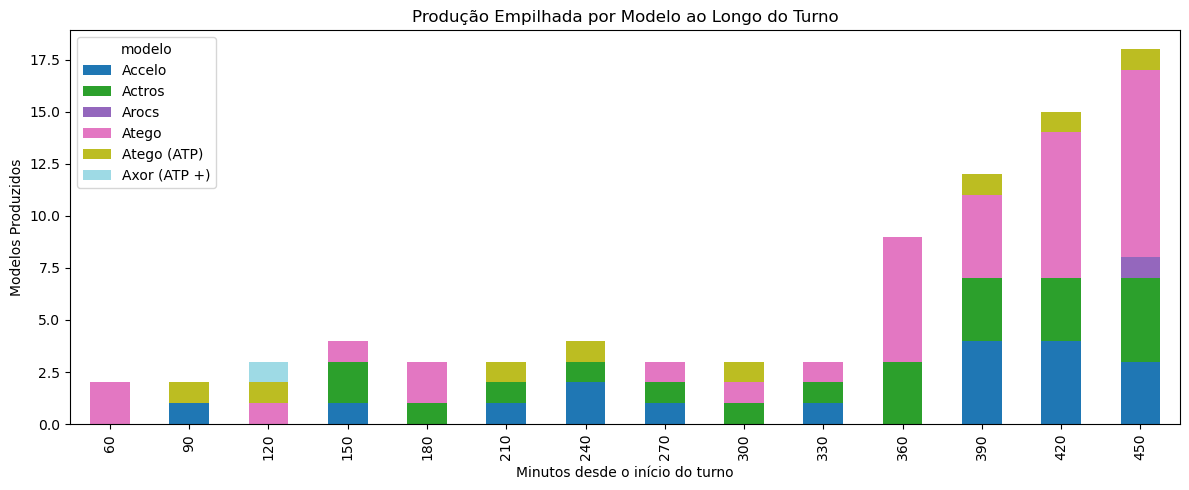

In [50]:
# Agrupar por modelo e intervalo de tempo (a cada 30 min)
modelos_completos["slot"] = (modelos_completos["saida_total"] // (30 * 60)).astype(int)

pivot = modelos_completos.groupby(["slot", "modelo"]).size().unstack(fill_value=0)

# Plot
pivot.index = pivot.index * 30  # converter slot em minutos
pivot.plot(kind="bar", stacked=True, figsize=(12, 5), colormap="tab20")
plt.xlabel("Minutos desde o início do turno")
plt.ylabel("Modelos Produzidos")
plt.title("Produção Empilhada por Modelo ao Longo do Turno")
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_17564\185744494.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


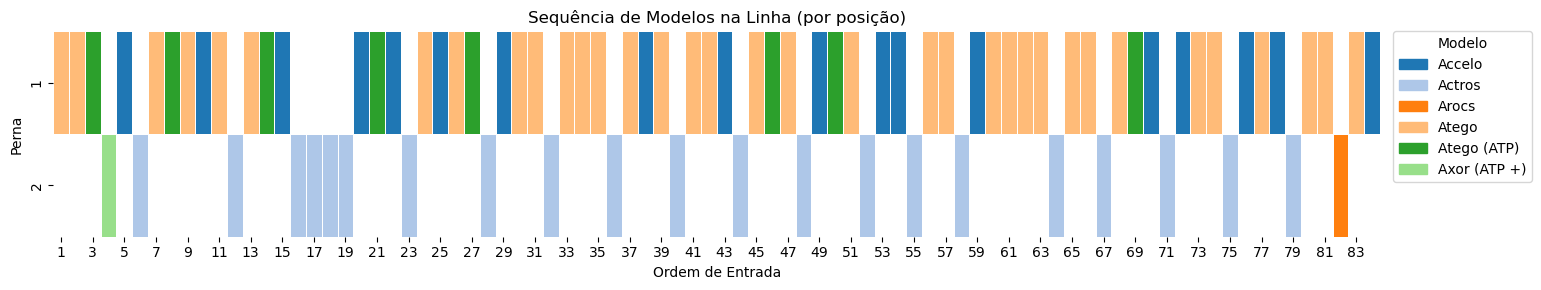

In [58]:

# 1. Organiza a sequência e pivota
sequencia = modelos_completos.reset_index().copy()
sequencia["ordem"] = sequencia["entrada_total"].rank(method='first').astype(int)

pivot = sequencia.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

# 2. Mapeia modelos para inteiros e cria mapa de cores
unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
int_to_modelo = {i: m for m, i in modelo_to_int.items()}

pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

# 3. Define paleta e cria lista de cores
palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}

# 4. Plota heatmap
plt.figure(figsize=(14, 3))
sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
plt.title("Sequência de Modelos na Linha (por posição)")
plt.xlabel("Ordem de Entrada")
plt.ylabel("Perna")
plt.tight_layout()

# 5. Cria legenda com cores
handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
plt.legend(
    handles=handles,
    title="Modelo",
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.show()

CÓDIGO ANTERIOR

In [ ]:

# def caminhao(env, id_caminhao, sequencia_modelos, fabrica, resultados):
#     tempo_entrada = env.now
   
#     # for modelo, info in MODELOS_CSV.items():
#     #     for b in info["baumuster"]:
#     #         if b in sequencia_modelos:
#     #             dados.append({"baumuster": b, "Modelo": modelo, "Perna": info["perna"]})

#     #     sequencia_atualizada = (pd.DataFrame(dados)).to_csv("sequencia_atualizada.csv", index=False)
#     #     print(f"baumuster {b} pertence ao modelo {modelo} e vai para a Perna {dados['perna']}")
    

#     modelos=[]
#     pernas=[]
#     for b in sequencia_modelos:
#         for modelo, info in MODELOS_CSV.items():
#             if b in info["baumuster"]:
#                 p = info['perna']
#                 if p == 1 :
#                 elif p == 2:

# # !!! TRAVAMOS AQUI !!!!!!
  
# # if modelo in ["Accelo", "Atego", "ATP"]: nome_linha = "Perna 1"
# # elif modelo in ["Actros", "Arocs"]: nome_linha = "Perna 2"

# #     else: return

# #     print(f"[{format_time(env.now)}] CHEGADA: Caminhão_{id_caminhao} ({modelo}) entrou na fila da {nome_linha}.")

#     operadores = fabrica['operadores'][nome_linha]
#     linha_especifica = fabrica['linhas'][nome_linha]
#     processos_modelo = PROCESSOS_FABRICA[modelo]
    
#     tempo_total_processo = sum(processos_modelo.values())
    
#     for nome_posto, tempo_proc in processos_modelo.items():
#         if nome_posto not in linha_especifica or tempo_proc <= 0: continue
        
#         posto = linha_especifica[nome_posto]
        
#         with posto.request() as req_posto, operadores.request() as req_operador:
#             yield req_posto & req_operador
            
#             yield env.timeout(tempo_proc)

#     tempo_saida = env.now
#     lead_time = tempo_saida - tempo_entrada
    
#     print(f"[{format_time(env.now)}] SAÍDA  : Caminhão_{id_caminhao} ({modelo}) finalizou. Lead Time: {format_time(lead_time)}")

#     resultados.append({
#         "ID": id_caminhao, "Modelo": modelo, "Linha": nome_linha,
#         "LeadTime_min": lead_time / 60,
#         "Tempo_Processo_min": tempo_total_processo / 60,
#         "Tempo_Espera_min": (lead_time - tempo_total_processo) / 60,
#         "Tempo_Saida_min": tempo_saida / 60,
#     })


In [ ]:

# # ETAPA 2: LÓGICA DA SIMULAÇÃO

# # EXTRAINDO BAUMUSTERS DA LISTA SEQUENCIA DO DIA
# sequencia = pd.read_csv("sequencia_producao.csv", sep=';')

# # Extrai os 7 primeiros caracteres da coluna 'Baumuster'
# sequencia['Baumuster_7dig'] = sequencia['Baumuster'].astype(str).str[:7]
# sequencia_modelos = sequencia["Baumuster_7dig"].tolist()
# print(sequencia_modelos)
# #print(sequencia[['Baumuster', 'Baumuster_7dig']].head(20))

# dados =[] 

# def format_time(segundos):
#     m, s = divmod(segundos, 60); h, m = divmod(m, 60)
#     return f"{int(h):02d}:{int(m):02d}:{int(round(s,0)):02d}"

 
# def caminhao(env, id_caminhao, sequencia_modelos, fabrica, resultados):
#     tempo_entrada = env.now
   
#     for modelo, info in MODELOS_CSV.items():
#         for b in info["baumuster"]:
#             if b in sequencia_modelos:
#                 dados.append({"baumuster": b, "Modelo": modelo, "Perna": info["perna"]})

#         sequencia_atualizada = (pd.DataFrame(dados)).to_csv("sequencia_atualizada.csv", index=False)
#         print(f"baumuster {b} pertence ao modelo {modelo} e vai para a Perna {dados['perna']}")
    
#     if modelo in ["Accelo", "Atego", "ATP"]: nome_linha = "Perna 1"
#     elif modelo in ["Actros", "Arocs"]: nome_linha = "Perna 2"

#     else: return

#     print(f"[{format_time(env.now)}] CHEGADA: Caminhão_{id_caminhao} ({modelo}) entrou na fila da {nome_linha}.")

#     operadores = fabrica['operadores'][nome_linha]
#     linha_especifica = fabrica['linhas'][nome_linha]
#     processos_modelo = PROCESSOS_FABRICA[modelo]
    
#     tempo_total_processo = sum(processos_modelo.values())
    
#     for nome_posto, tempo_proc in processos_modelo.items():
#         if nome_posto not in linha_especifica or tempo_proc <= 0: continue
        
#         posto = linha_especifica[nome_posto]
        
#         with posto.request() as req_posto, operadores.request() as req_operador:
#             yield req_posto & req_operador
            
#             yield env.timeout(tempo_proc)

#     tempo_saida = env.now
#     lead_time = tempo_saida - tempo_entrada
    
#     print(f"[{format_time(env.now)}] SAÍDA  : Caminhão_{id_caminhao} ({modelo}) finalizou. Lead Time: {format_time(lead_time)}")

#     resultados.append({
#         "ID": id_caminhao, "Modelo": modelo, "Linha": nome_linha,
#         "LeadTime_min": lead_time / 60,
#         "Tempo_Processo_min": tempo_total_processo / 60,
#         "Tempo_Espera_min": (lead_time - tempo_total_processo) / 60,
#         "Tempo_Saida_min": tempo_saida / 60,
#     })

# def gerador_de_producao(env, fabrica, resultados, takt_time):
#     id_caminhao = 0
#     modelos_perna1 = [m for m in PROCESSOS_FABRICA.keys() if m in ["Accelo", "Atego", "ATP"]]
#     modelos_perna2 = [m for m in PROCESSOS_FABRICA.keys() if m in ["Actros", "Arocs"]]

#     while True:
#         id_caminhao += 1
        
#         if random.random() < 0.80 and modelos_perna1: 
#             modelo_escolhido = random.choice(modelos_perna1)
#         elif modelos_perna2:
#             modelo_escolhido = random.choice(modelos_perna2)
#         else:
#             modelo_escolhido = random.choice(list(PROCESSOS_FABRICA.keys()))

#         env.process(caminhao(env, id_caminhao, modelo_escolhido, fabrica, resultados))
#         yield env.timeout(takt_time)



In [ ]:
# ETAPA 3: EXECUÇÃO E RELATÓRIOS

# if not PROCESSOS_FABRICA:
#     print("\n[ERRO FATAL] Nenhum dado foi carregado.")
# else:
#     # --- ESTRUTURA ---
#     env = simpy.Environment()
#     resultados_simulacao = []
    
#     fabrica = {
#         "operadores": {
#             "Perna 1": simpy.Resource(env, capacity=NUM_OPERADORES_PERNA1),
#             "Perna 2": simpy.Resource(env, capacity=NUM_OPERADORES_PERNA2)
#         }, "linhas": {"Perna 1": {}, "Perna 2": {}}
#     }
    
#     postos_p1 = set().union(*(p.keys() for m, p in PROCESSOS_FABRICA.items() if m in ["Accelo", "Atego", "ATP"]))
#     fabrica['linhas']['Perna 1'] = {posto: simpy.Resource(env, capacity=1) for posto in postos_p1}
#     postos_p2 = set().union(*(p.keys() for m, p in PROCESSOS_FABRICA.items() if m in ["Actros", "Arocs"]))
#     fabrica['linhas']['Perna 2'] = {posto: simpy.Resource(env, capacity=1) for posto in postos_p2}
    
#     # --- EXECUÇÃO ---
#     print("\n--- Iniciando Simulação: Cenário 'As-Is' Real ---")
#     print(f"Takt Time: {TAKT_TIME_SEGUNDOS/60:.2f} min | Perna 1: {NUM_OPERADORES_PERNA1} op. | Perna 2: {NUM_OPERADORES_PERNA2} op.")
    
#     env.process(gerador_de_producao(env, fabrica, resultados_simulacao, TAKT_TIME_SEGUNDOS))
#     env.run(until=HORAS_SIMULACAO * 3600)
    
#     print("\n" + "="*60)
#     print("      RELATÓRIO GERENCIAL DA SIMULAÇÃO (AS-IS)")
#     print("="*60)

#     # --- ANÁLISE DOS RESULTADOS ---
#     df_resultados = pd.DataFrame(resultados_simulacao)
    
#     if df_resultados.empty:
#         print("\nNenhum caminhão completou a produção.")
#     else:
#         # 1. Análise da Meta de Produção
#         df_meta_batida = df_resultados[df_resultados['Tempo_Saida_min'] <= HORAS_META * 60]
#         qtd_na_meta = len(df_meta_batida)
        
#         print("\n--- 1. ANÁLISE DA META DE PRODUÇÃO (c/ 'Fator Cagaço') ---")
#         if qtd_na_meta >= META_PRODUCAO:
#             print(f" SUCESSO! A meta foi batida, com {qtd_na_meta} caminhões produzidos nas primeiras {HORAS_META} horas.")
#         else:
#             print(f" FALHA! Apenas {qtd_na_meta} de {META_PRODUCAO} caminhões foram produzidos nas primeiras {HORAS_META} horas.")

#         # 2. Análise de Desempenho
#         print("\n--- 2. DESEMPENHO POR PERNA ---")
#         desempenho = df_resultados.groupby('Linha').agg(
#             Qtd_Produzida=('ID', 'count'),
#             Lead_Time_Medio_min=('LeadTime_min', 'mean'),
#             Tempo_Medio_Espera_min=('Tempo_Espera_min', 'mean')
#         ).round(2)
#         print(desempenho)

#         # 3. Novo Relatório Visual
#         print("\n--- 3. Gerando Relatório Visual Gerencial ---")
#         fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1]})
#         fig.suptitle('Relatório Gerencial da Simulação (Cenário As-Is Real)', fontsize=20)

#         # Gráfico 1: Produção por Perna
#         prod_counts = df_resultados['Linha'].value_counts().reindex(['Perna 1', 'Perna 2']).fillna(0)
#         sns.barplot(x=prod_counts.index, y=prod_counts.values, ax=axes[0], palette='viridis', hue=prod_counts.index, legend=False)
#         axes[0].set_title('Produção Total por Perna', fontsize=16)
#         axes[0].set_ylabel('Qtd. de Caminhões Produzida')
#         axes[0].set_ylim(0, prod_counts.max() * 1.15)
#         for i, v in enumerate(prod_counts.values):
#             axes[0].text(i, v, str(int(v)), ha='center', va='bottom', fontsize=14)
        
#         # Gráfico 2: Lead Time por Perna
#         sns.boxplot(x='Linha', y='LeadTime_min', data=df_resultados, ax=axes[1], palette='coolwarm', hue='Linha', order=['Perna 1', 'Perna 2'], legend=False)
#         axes[1].set_title('Lead Time por Perna', fontsize=16)
#         axes[1].set_ylabel('Tempo Total de Produção (minutos)')
        
#         plt.tight_layout(rect=[0, 0, 1, 0.96])
#         plt.savefig('relatorio_gerencial_real.png')
#         print(" SUCESSO: Gráfico 'relatorio_gerencial_real.png' salvo.")